<a href="https://colab.research.google.com/github/rrrajjjj/TinySOL/blob/main/TinySOL_Instrument_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [ ]:
!pip install torch torchvision torchaudio
!pip uninstall -y torchtext
!pip install pytorch-lightning
!pip install mirdata scikit-learn
!pip install torchmetrics
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

## Import libraries

In [ ]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torchaudio

# MIR Libraries
import mirdata
import essentia.standard as ess

# set constants
random_seed = 32



## TinySOL - Dataset for Instrument Classification






TinySOL is a dataset of 2478 samples, each containing a single musical note from one of 14 different instruments:

1.  Bass Tuba
2.  French Horn
3.  Trombone
4. Trumpet in C
5. Accordion
6. Contrabass
7. Violin
8. Viola
9. Violoncello
10. Bassoon
11. Clarinet in B-flat
12. Flute
13. Oboe
14. Alto Saxophone



These sounds were originally recorded at Ircam in Paris (France) between 1996 and 1999, as part of a larger project named Studio On Line (SOL). Although SOL contains many combinations of mutes and extended playing techniques, TinySOL purely consists of sounds played in the so-called "ordinary" style, and in absence of mute.




In [ ]:
tinysol = mirdata.initialize("tinysol")

In [ ]:
tinysol.download()

INFO: Downloading ['audio', 'annotations'] to /root/mir_datasets/tinysol
INFO: [audio] downloading TinySOL.tar.gz
979MB [00:55, 18.5MB/s]                           
INFO: [annotations] downloading TinySOL_metadata.csv
312kB [00:02, 114kB/s]                           


In [ ]:
tinysol

The tinysol dataset
----------------------------------------------------------------------------------------------------


Call the .cite method for bibtex citations.
----------------------------------------------------------------------------------------------------


tinysol Track class

    Args:
        track_id (str): track id of the track

    Attributes:
        audio_path (str): path of the audio file
        dynamics (str): dynamics abbreviation. Ex: pp, mf, ff, etc.
        dynamics_id (int): pp=0, p=1, mf=2, f=3, ff=4
        family (str): instrument family encoded by its English name
        instance_id (int): instance ID. Either equal to 0, 1, 2, or 3.
        instrument_abbr (str): instrument abbreviation
        instrument_full (str): instrument encoded by its English name
        is_resampled (bool): True if this sample was pitch-shifted from a neighbor; False if it was genuinely recorded.
        pitch (str): string containing English pitch class and octave number
    

# Exploring the data

In [ ]:
annotations = pd.read_csv("/root/mir_datasets/tinysol/annotation/TinySOL_metadata.csv")
annotations.head()

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False


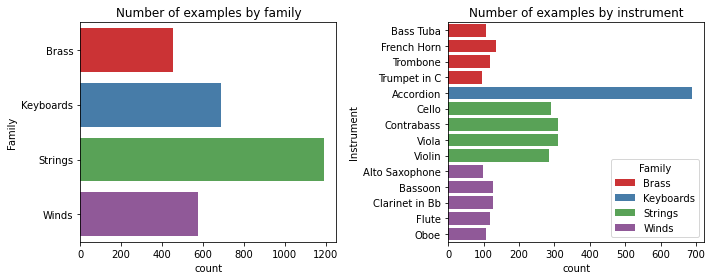

In [ ]:
# Class distribution
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
sns.countplot(y = "Family", data = annotations, palette = "Set1", dodge = False )
plt.ylabel("Family")
plt.title("Number of examples by family")

plt.subplot(1, 2, 2)
sns.countplot(y = "Instrument (in full)", hue = "Family", data = annotations, palette = "Set1" , dodge = False)
plt.ylabel("Instrument")
plt.title("Number of examples by instrument")


plt.tight_layout()

## Class Imbalance
At the instrument level, there is a significant class imbalance with the accordion having ~700 examples while most brass and wind instruments have only ~100. At the family level the imbalance is tipped towards strings. This problem can be tackled in 3 ways - 
1. Undersampling the abundant class - The simplest solution would be to undersample the accordion to a lower number of examples. 

2. Using weighted cost functions - The class imbalance can be used to inform the cost function such that the model is more heavily penalised for making errors for rarer classes. 

3. Data Augmentation - The rare classes can be selectively augmented either by storing the augmented version on the disk before training or augmenting online as the training goes on. This would be an addition once a baseline is established. 

## Pitch Class and Range Distribution

How are the samples distributed accross different pitch classes and in different octaves (pitch ranges)?

INFO: NumExpr defaulting to 2 threads.


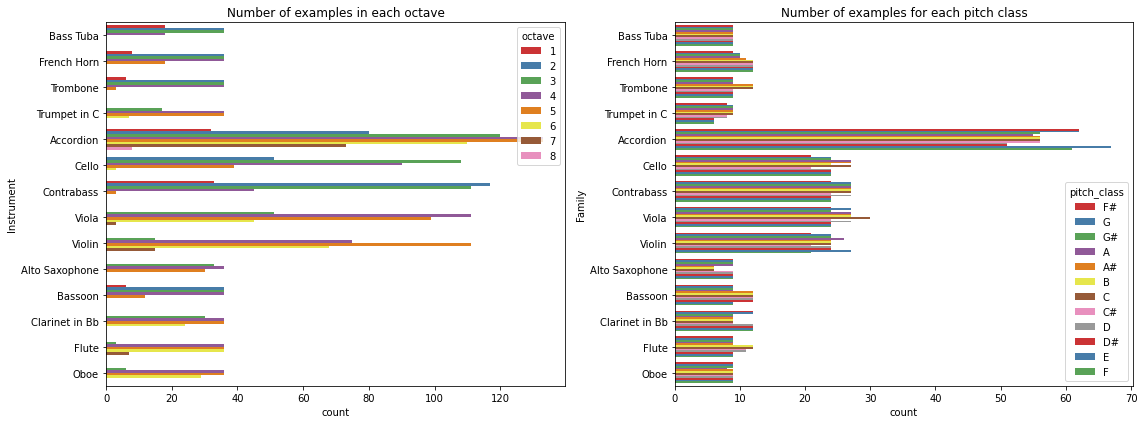

In [ ]:
# separate pitch class and octave information
annotations["octave"] = [int(i[-1]) for i in annotations["Pitch"]]
annotations["pitch_class"] = [i[:-1] for i in annotations["Pitch"]]

# plots
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)
sns.countplot(y = "Instrument (in full)", hue = "octave", data = annotations, palette = "Set1" )
plt.ylabel("Instrument")
plt.title("Number of examples in each octave")

plt.subplot(1, 2, 2)
sns.countplot(y = "Instrument (in full)", hue = "pitch_class", data = annotations, palette = "Set1" )
plt.ylabel("Family")
plt.title("Number of examples for each pitch class")
plt.tight_layout()



## Duration of the audio files

In [ ]:
# Get durations of each audio file 
durations = []
for i in range(annotations.shape[0]):
  path = "/root/mir_datasets/tinysol/audio/" + annotations.loc[i]["Path"]
  metadata = torchaudio.info(path)
  durations.append(metadata.num_frames/metadata.sample_rate)

annotations["duration"] = durations

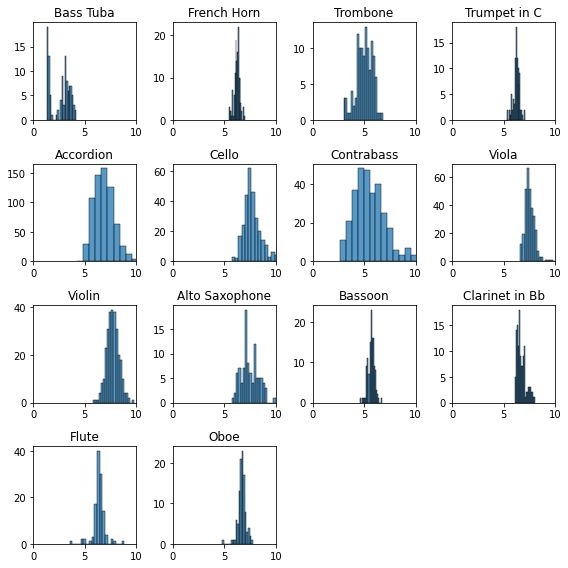

In [ ]:
# plot the instrument wise distribution of durations
instruments = annotations["Instrument (in full)"].unique()
plt.figure(figsize=(8, 8))
for i, inst in enumerate(instruments):
  plt.subplot(4, 4, i+1)
  sns.histplot(x = "duration",
               data = annotations[annotations["Instrument (in full)"] == inst],
               bins = 20)
  plt.xlim((0, 10))
  plt.xlabel("")
  plt.ylabel("")
  plt.title(inst)
plt.tight_layout()

Most audio files have a length between 5 and 10 seconds. There are some very short files (< 2s) for the Bass Tuba. 

# Instrument Classification

## Extract features

There are many single instruments with less than 100 training examples, so a coarse grained classification at the family level is attempted.

In [ ]:
tinysol_ids = tinysol.track_ids  # Load tinysol IDs
tinysol_data = tinysol.load_tracks()  # Load tinysol data
tinysol_data[tinysol_ids[0]]  # Visualize a single track

Track(
  audio_path="/root/mir_datasets/tinysol/audio/Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav",
  track_id="BTb-ord-F#1-pp-N-N",
  audio: The track's audio

        Returns,
  dynamics: ,
  dynamics_id: ,
  family: ,
  instance_id: ,
  instrument_abbr: ,
  instrument_full: ,
  is_resampled: ,
  pitch: ,
  pitch_id: ,
  split: ,
  string_id: ,
  technique_abbr: ,
  technique_full: ,
)

In [ ]:
# Get complete list of different instruments and families
family_names = annotations["Family"].unique()
inst_names = annotations["Instrument (in full)"].unique()

print(f"The dataset contains the following families - \n\n{family_names} \n\nContaining the following instruments -\n\n{inst_names}")

The dataset contains the following families - 

['Brass' 'Keyboards' 'Strings' 'Winds'] 

Containing the following instruments -

['Bass Tuba' 'French Horn' 'Trombone' 'Trumpet in C' 'Accordion' 'Cello'
 'Contrabass' 'Viola' 'Violin' 'Alto Saxophone' 'Bassoon' 'Clarinet in Bb'
 'Flute' 'Oboe']


In [ ]:
# Create a dictionary using instrument type as keys
inst_dict = {item: [] for item in inst_names}

for i in tinysol_ids:
    inst_dict[tinysol_data[i].instrument_full].append(tinysol_data[i].audio_path)



Plot waveforms of random samples of each instrument...


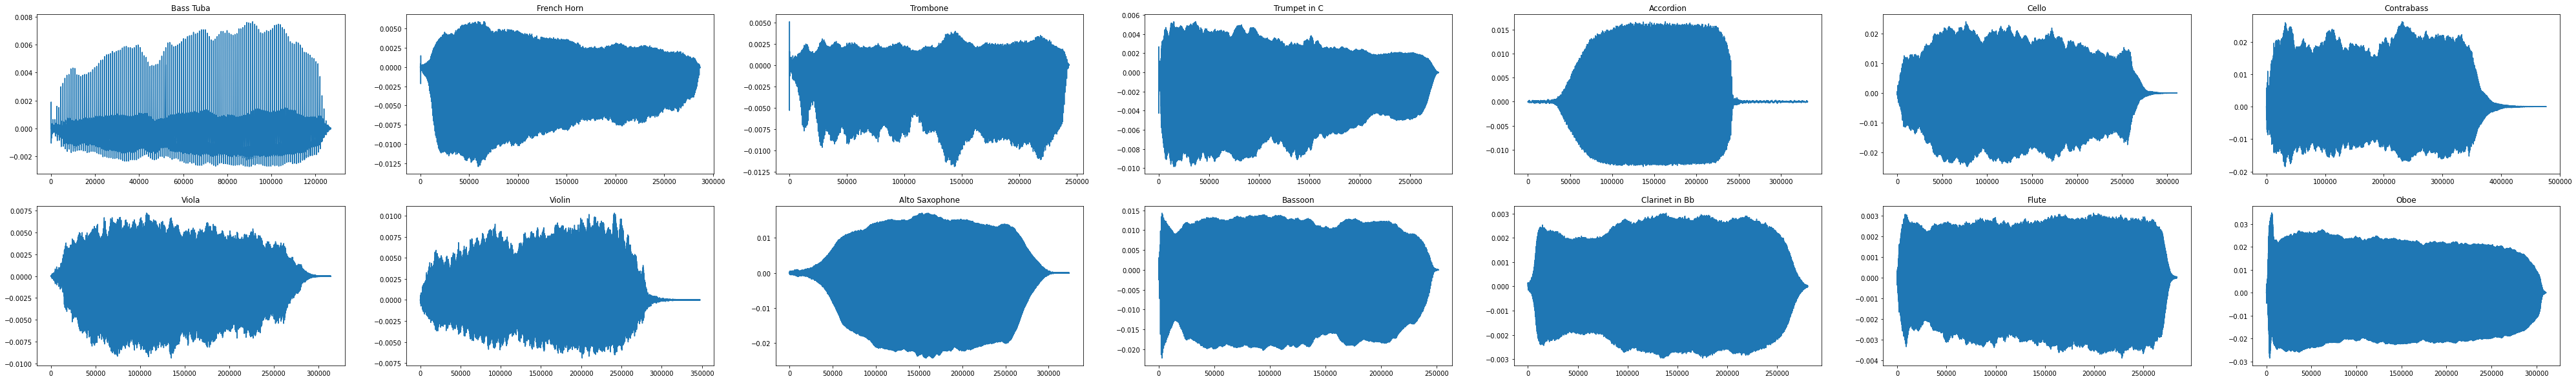

In [ ]:
_, fs = tinysol_data[tinysol_ids[0]].audio

num_inst = len(inst_names)
print("Plot waveforms of random samples of each instrument...")
plt.figure(1, figsize=(5 * num_inst, 10))
file_ind_inlist = 1 # 1: let's take the first file in the list for sample plots
for i, inst in enumerate(inst_dict.keys()):
    sample_file = inst_dict[inst][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(2,num_inst//2,(i+1))
    plt.plot(x)
    plt.title(inst)

## Preprocessing: Removing bits of silence

---



There are regions of silence in the files. It'd be helpful for classification to split the audio based on an energy threshold and use only regions without silence for training our classifier. 

In [ ]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [ ]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)

    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


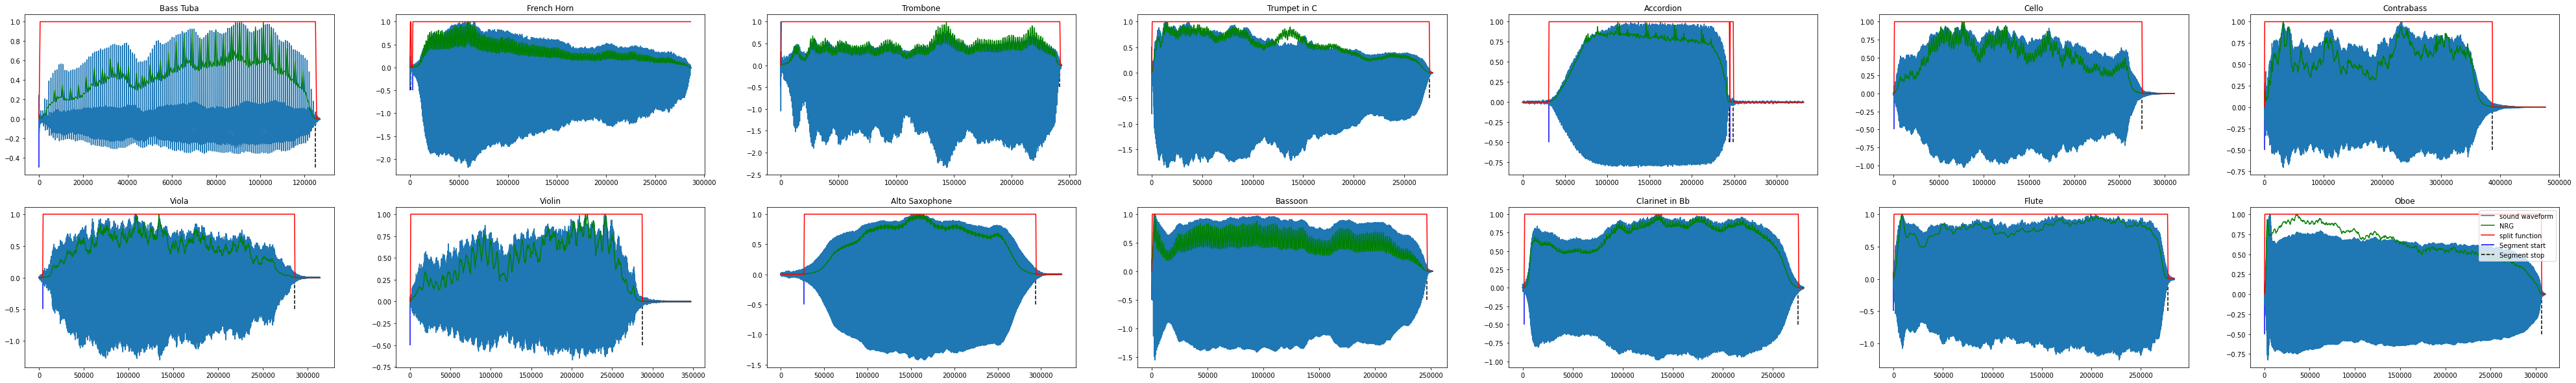

In [ ]:
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_inst, 10))
    for i, inst in enumerate(inst_dict.keys()):
        sample_file = inst_dict[inst][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(2,num_inst//2,(i+1))
        plt.title(inst)
        plt.plot(x/np.max(x), label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [ ]:
# create segment files
main_data_dir = 'sample_data'
if not os.path.exists(main_data_dir): #creating the directory
    os.mkdir(main_data_dir)
segments_dir = os.path.join(main_data_dir,'segments')
if not os.path.exists(segments_dir): #creating the directory
    os.mkdir(segments_dir)

segment_files = []
for inst, files in inst_dict.items():
    for sample_file in files:        
        # split
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        # normalise amplitude
        x = x/np.max(np.abs(x))

        #Croping segments
        for start, stop in zip(start_indexes, stop_indexes):
            x_seg = x[start: stop]
            #Final check for amplitude (to avoid silent segments selection due to noise in split function)
            if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, "/".join(sample_file.split("/")[-4:]))
                penultimate_dir = "/".join(filename.split("/")[:-1])
                if not os.path.exists(penultimate_dir): 
                    os.makedirs(penultimate_dir)
                ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                segment_files.append(filename)

print(len(segment_files),'segment files created')

2337 segment files created


In [ ]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

#delete_files_in_dir(segments_dir)

## Feature extraction 


In [ ]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(tinysol_data[tinysol_ids[0]].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running musicextractor for all files, keeping a subset of features, writing to an output file: data.csv

In [ ]:

# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element
data_file = 'sample_data/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['family', 'inst']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for filename in segment_files:
        file_count +=1
        if file_count % 20 == 0: #print name of a file every 20 files
            print(file_count, "files processed, current file: ", filename)

        #Compute and write features for file
        features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(filename)
        selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
        family_label = filename.split('/')[-4]
        inst_label = filename.split('/')[-3]
        line2write = str(selected_features)[1:-1] + ',' + family_label + "," + inst_label + '\n'
        writer.write(line2write)
print("A total of ", file_count, "files processed")

In [ ]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,family,inst
0,0.972548,8.393708,1.001293,0.450970,0.045677,9.485742,18.930441,1.133445,1.270571,1.872781,0.605961,0.465184,0.055924,2.027252,7.852919,0.988877,0.345795,0.050579,10.199882,7.212583,1.030934,0.949974,5.286511,5.615246,10.295513,5.544564,-14.813866,0.009389,-15.087656,1.642588,-15.012844,0.004694,16.125177,1.659799,0.604403,0.048697,6.531901,17.421295,1.342234,0.755168,...,0.946565,0.224900,0.030534,0.172052,211.343460,18.682755,5.938931,2.185154,-1.624015e-08,8.140049e-09,0.062228,0.031224,0.000004,4.376439e-07,0.040657,0.018252,0.000002,0.000003,0.030491,0.017364,4.932230,0.325067,0.024831,0.009686,63.817249,25.561995,0.007454,0.002268,246.234650,38.930977,7.000915,1.532057,1902200.000,1293280.125,0.311751,0.093810,0.006545,0.003231,Brass,Bass_Tuba
1,0.987934,7.666599,0.928217,0.435474,0.041419,9.425517,14.807987,1.044590,1.105360,1.874597,0.372849,0.474454,0.052759,1.841267,7.476386,0.912190,0.339779,0.045184,9.366020,5.920585,1.006098,0.816409,5.383473,4.133899,9.961066,4.827472,-14.728214,0.000000,-14.975849,1.558700,-15.212446,0.000000,15.323725,1.767128,0.586096,0.044219,6.388059,17.144968,1.383626,0.734776,...,0.967480,0.177377,0.024390,0.154257,219.245453,19.263578,7.203252,2.067791,-1.483790e-08,6.718702e-09,0.056905,0.025794,0.000005,3.373184e-07,0.035489,0.014165,0.000003,0.000004,0.032403,0.016002,5.011564,0.306822,0.033377,0.012842,57.900490,20.086861,0.007186,0.001971,262.775116,39.501488,6.694112,1.277137,1898403.875,1159358.500,0.574201,0.607506,0.007273,0.003383,Brass,Bass_Tuba
2,0.977007,6.879488,1.238681,0.462037,0.027249,2.462419,12.778818,0.364497,0.866103,2.304536,0.290590,0.461754,0.065742,1.500641,9.363842,0.967631,0.404369,0.040748,2.794973,5.509210,-0.045090,0.726124,4.207346,1.877057,12.278924,4.785673,-14.715645,0.154634,-14.846140,1.120028,-14.716234,0.055947,11.761684,2.484964,0.615519,0.029111,1.247414,11.193150,0.729306,0.526918,...,1.000000,0.000000,0.021583,0.145317,273.134979,26.310354,9.000000,2.211806,-1.394042e-08,4.995063e-09,0.053728,0.019273,0.000001,1.084154e-07,0.022808,0.008208,0.000006,0.000004,0.037986,0.014341,4.944

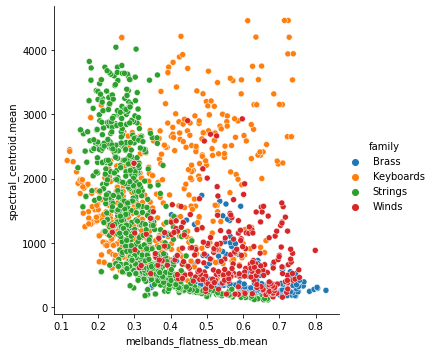

In [ ]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "family", data = data)


### Preprocessing of the features


In [ ]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [ ]:
data_modif.family.value_counts()

Keyboards    1032
Strings       818
Winds         266
Brass         221
Name: family, dtype: int64

In [ ]:
# pick 266 as the minimum
min_number = data_modif.family.value_counts()['Winds']
keys_data = data_modif[data_modif.family == 'Keyboards'].sample(n = min_number, random_state = 42)
strings_data = data_modif[data_modif.family == 'Strings'].sample(n = min_number, random_state = 42)
winds_data = data_modif[data_modif.family == 'Winds']
brass_data = data_modif[data_modif.family == 'Brass']

#Merging after downsampling
data_modif = pd.concat([keys_data, strings_data, winds_data, brass_data])
#Checking the balance again
data_modif.family.value_counts()

Keyboards    266
Strings      266
Winds        266
Brass        221
Name: family, dtype: int64

## Support Vector Machine

In [ ]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.family = pd.Categorical(data_modif.family)  # convert to categorical data
y = np.array(data_modif.family.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [9.78979792e-01 6.69514155e-01 9.36750120e-02 6.91681091e-01
 2.60214033e-01 1.15318701e-04 2.91685338e-04 2.64778315e-01
 1.14896950e-02 1.50453645e-01 2.30230420e-02 9.43045843e-01
 1.81441971e-01 8.12550678e-02 6.33248973e-01 1.34651606e-01
 6.79247817e-01 1.97069533e-01 8.09825439e-03 3.45784409e-02
 4.68807469e-01 3.77160725e-02 1.08281214e-01 2.31068081e-02
 1.15803164e-01 4.38470915e-02 8.62567859e-01 6.35464792e-02
 8.62611704e-01 9.20222504e-02 8.89519292e-01 6.83750742e-02
 7.39462611e-01 6.68707660e-02 6.16951473e-01 1.89086452e-01
 4.76955568e-03 1.33512260e-03 5.13969652e-01 2.66978058e-02
 1.12387025e-01 3.03769882e-02 4.93179155e-01 1.30424556e-01
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 2.40154582e-02 1.89573319e-01 6.38109930e-01 1.10366859e-01
 4.80098809e-02 1.19492478e-02 9.93565732e-01 1.82933388e-03
 7.89408096e-03 2.22871308e-03 1.25762913e-01 3.56042812e-02
 5.79556800e-07 1.19668303e-06 3.65975704e-01 7.763975

In [ ]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (682, 84) , Size of train output vector:  (682,)
Size of test features matrix:  (337, 84) , Size of test output vector:  (337,)


In [ ]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [ ]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.8605341246290801


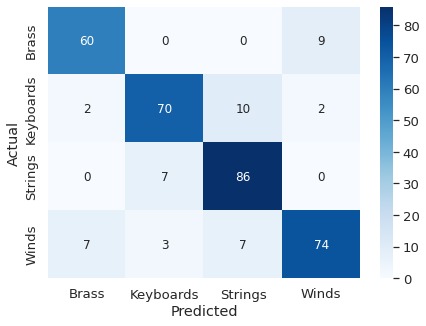

In [ ]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.family)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Neural Network



In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (815, 4)
One-hot encoded y_test shape =  (204, 4)


In [ ]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [ ]:
model.summary()  # Plot summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization_2 (Batc  (None, 40)               160       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 40)                0         
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)               

In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 32, epochs = 250, validation_split=0.2, verbose=0)

In [ ]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1059034913778305
Test accuracy: 0.9166666865348816


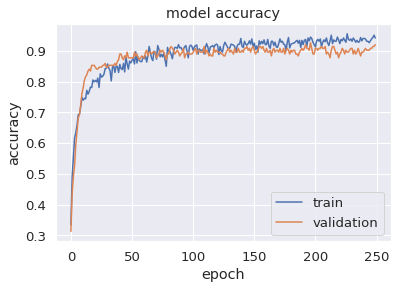

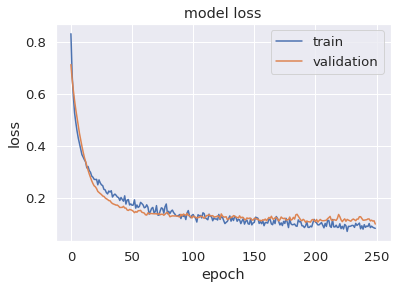

In [ ]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Results for classification at the family level



---------------------------------
| Model          | Accuracy     |
-----------------::|::---------------
| SVM            |     86.05%   |
|Neural Network  |     91.6%    |


